<a href="https://colab.research.google.com/github/kingattai/ml-lime-malaria-prediction/blob/main/XGB_Conference_MAL_with_RiskFactors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install treeinterpreter

In [ ]:
!pip install imbalanced-learn

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, log_loss, classification_report,
                             confusion_matrix, roc_auc_score)
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from treeinterpreter import treeinterpreter as ti
from sklearn.inspection import PartialDependenceDisplay

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 1. Load dataset
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NFRF ML/Mal_Data.csv')
df2 = df.drop(df.columns[0], axis=1)  # Drop first index/ID column

In [ ]:
# 3. Split into features and target
X = df2.iloc[:, :-1].values
y = df2.iloc[:, -1].values

In [ ]:
# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("Class distribution after SMOTE:", np.bincount(y_train_smote))

Class distribution after SMOTE: [2699 2699]


In [ ]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
param_grid_xgb = {'n_estimators': [100, 200], 'max_depth': [3, 5]}
grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_xgb.fit(X_train_smote, y_train_smote)
best_xgb_model = grid_search_xgb.best_estimator_

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:20:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# Prediction and Evaluation
y_pred_xgb = best_xgb_model.predict(X_test)
y_prob_xgb = best_xgb_model.predict_proba(X_test)
print("Best parameters:", grid_search_xgb.best_params_)
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_xgb, average='weighted'):.4f}")
print(f"Log Loss: {log_loss(y_test, y_prob_xgb):.4f}")
if len(np.unique(y_test)) == 2:
    print(f"AUC-ROC: {roc_auc_score(y_test, y_prob_xgb[:, 1]):.4f}")

Best parameters: {'max_depth': 5, 'n_estimators': 100}

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.78      0.75       323
           1       0.89      0.85      0.87       651

    accuracy                           0.83       974
   macro avg       0.80      0.81      0.81       974
weighted avg       0.83      0.83      0.83       974

Accuracy: 0.8255
Precision: 0.8303
Recall: 0.8255
F1 Score: 0.8272
Log Loss: 0.4264
AUC-ROC: 0.8832


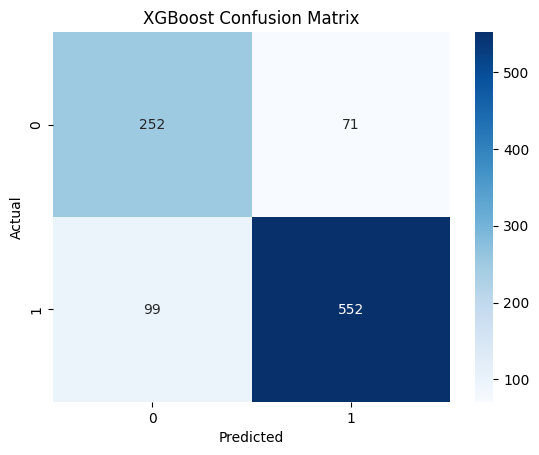

In [ ]:
# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('XGBoost Confusion Matrix')
plt.show()

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=c5d10cc47f91248d21e99bf10e17f0504f9cd0a737c7b144fb9e82ec69f313c0
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import lime
import lime.lime_tabular

In [ ]:
# If you used NumPy arrays, convert to DataFrame for feature names
if isinstance(X_train, np.ndarray):
    feature_names = df2.dropna(axis=1).columns[:-1]  # Exclude target column
    X_train_df = pd.DataFrame(X_train, columns=feature_names)
    X_test_df = pd.DataFrame(X_test, columns=feature_names)
else:
    feature_names = X_train.columns
    X_train_df = X_train
    X_test_df = X_test

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_df.values,
    feature_names=feature_names,
    class_names=['No Disease', 'Disease'],
    mode='classification',
    discretize_continuous=True
)


 LIME Explanation (XGBoost):


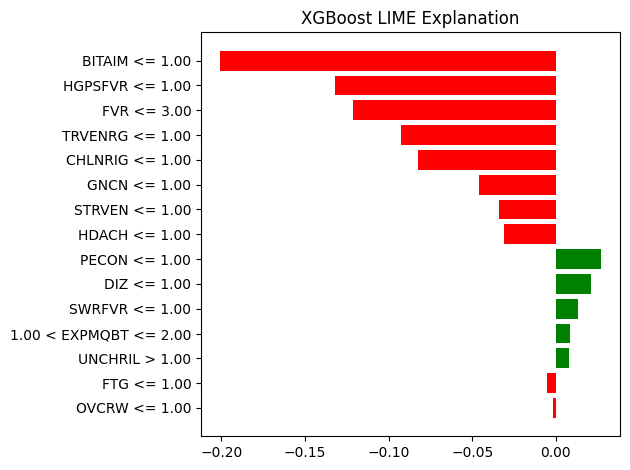

In [ ]:
i = 0
exp_xgb = explainer.explain_instance(
    X_test_df.iloc[i].values,
    best_xgb_model.predict_proba,
    num_features=len(feature_names)
)

# Show explanation
print("\n LIME Explanation (XGBoost):")
fig = exp_xgb.as_pyplot_figure()
plt.title("XGBoost LIME Explanation")
plt.tight_layout()
plt.show()